## Snowpack Temperature Model (USGS Data)

This notebook implements a multi-layer 1D snowpack temperature model using **USGS NWIS data**.

**Data source:** Senator Beck and Ptarmigan meteorological stations via `usgs_collector.py`

**Key features:**
- **Heat conduction**: Between snow layers
- **Shortwave (SW) radiation**: Two-band absorption (VIS + NIR)
- **Longwave (LW) radiation**: Measured or parameterized
- **Turbulent fluxes**: Sensible and latent heat
- **Melt/refreeze**: Simple latent cooling clamp

**Validation**: Modeled surface temperature vs USGS non-contact surface temperature (`72405`)


In [1]:
import numpy as np
import math
from math import erf, sqrt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
import ipywidgets as widgets
import datetime
import pandas as pd

# USGS Data Collector
from usgs_collector import fetch_usgs_iv, simplify_columns, STATIONS

## Constants and Parameters

Physical constants and model configuration. All units are SI.

In [2]:
# =============================================================================
# USGS DATA CONFIGURATION
# =============================================================================
STATION = "senator_beck"      # Options: "senator_beck", "ptarmigan"
STATIONS_PROJECT = {
        "independence_pass": "390622106343001",
        "berthoud_pass": "394759105464101",
        "senator_beck": "375429107433201",
    }
START_DATE = "2026-01-01"     # Format: YYYY-MM-DD
END_DATE = "2026-01-31"       

# =============================================================================
# PHYSICAL CONSTANTS (SI Units)
# =============================================================================
sigma    = 5.67e-8          # Stefan-Boltzmann constant (W/m²/K⁴)
Lv_subl  = 2.83e6           # Latent heat of sublimation (J/kg)
z_ref    = 2.0              # Effective bulk-exchange reference height (m)
Lf       = 3.34e5           # Latent heat of fusion (J/kg)
CH = 0.0022                  # Sensible heat transfer coefficient .002-.0022
CE = 0.0022                  # Latent heat transfer coefficient .002-.0022

# =============================================================================
# SNOWPACK PARAMETERS
# =============================================================================
N = 35                      # Number of layers
snow_depth_m = 1.5          # Total snow depth (m) - static for now
eps_snow   = 0.99           # Snow emissivity (.97-.99)
c_snow = 2100.0             # Snow specific heat capacity (J/kg·K)
rho_snow = 200.0            # Snow density (kg/m³)
alpha_snow = 0.80           # Albedo of snow surface
k        = 0.22              # Snow thermal conductivity (W/m·K) .2-.22

# =============================================================================
# AIR PARAMETERS (for ~3700m elevation)
# =============================================================================
rho_air = 0.84              # Air density (kg/m³)
c_pa     = 1005.0           # Specific heat of air (J/kg·K)
p_air = 65000               # Air pressure (Pa)

# =============================================================================
# MODEL OPTIONS
# =============================================================================
use_twoBand = True               # Two-band SW absorption
run_measured_only = True
use_idealized_LWin = False       # Use measured LW (set True for parameterized)
use_idealized_SWout = False      # Use measured SW_out (set True for constant albedo)

USE_SKIN_DIAGNOSTIC = True       # Use near-surface skin diagnostic for comparison

SKIN_BETA = 0.20                 # Skin extrapolation weight (0.0=off, 0.2 recommended)
show_plots = True                # Show diagnostic plots
generate_animation = False        # Generate temperature profile animation
# n_days = 60                     # Simulation duration (days)
dt_max = 1800                    # Maximum timestep (seconds)
# t_end = n_days * 24 * 3600       # End time (seconds)

## Load USGS Data

Fetch meteorological data directly from USGS NWIS API and create interpolators for the solver.

In [3]:
# =============================================================================
# DATA ACQUISITION & INTERPOLATION
# =============================================================================
print(f"Fetching USGS data for {STATION} from {START_DATE} to {END_DATE}...")

try:
    df_raw = fetch_usgs_iv(STATIONS[STATION], START_DATE, END_DATE)
    df = simplify_columns(df_raw)
    
    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    
    # Data QC
    df = df[~df.index.duplicated(keep="first")].copy()

    required_cols = [
        "air_temp_c", "rh_pct", "wind_speed_mph",
        "sw_down_wm2", "sw_up_wm2", "lw_down_wm2",
        "snow_depth_m", "surface_temp_c"
    ]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    rows_before = len(df)
    df = df.dropna(subset=required_cols).copy()

    # Physical bounds
    df["rh_pct"] = df["rh_pct"].clip(lower=0, upper=100)
    df["wind_speed_mph"] = df["wind_speed_mph"].clip(lower=0)
    df["sw_down_wm2"] = df["sw_down_wm2"].clip(lower=0)
    df["sw_up_wm2"] = df["sw_up_wm2"].clip(lower=0)
    df["lw_down_wm2"] = df["lw_down_wm2"].clip(lower=0)
    if "lw_up_wm2" in df.columns:
        df["lw_up_wm2"] = df["lw_up_wm2"].clip(lower=0)

    # Keep at least 10 cm depth for numerical stability
    df["snow_depth_m"] = df["snow_depth_m"].clip(lower=0.10)

    # Hard safety check for SW
    if (df["sw_down_wm2"] < 0).any() or (df["sw_up_wm2"] < 0).any():
        raise ValueError("QC failed: negative shortwave values remain.")

    print(f"QC rows before: {rows_before}")
    print(f"QC rows after : {len(df)}")
    print(f"Min SW down   : {float(df['sw_down_wm2'].min()):.3f}")
    print(f"Min SW up     : {float(df['sw_up_wm2'].min()):.3f}")


    # Create time arrays
    times_arr = (df.index - df.index[0]).total_seconds().values
    times_sec = times_arr
    t_end = float(times_sec[-1])
    print(f"Model duration: {t_end/86400:.2f} days")

    def make_interp(x, y):
        y = np.asarray(y, dtype=float)
        return interp1d(
            x,
            y,
            kind="linear",
            bounds_error=False,
            fill_value=(y[0], y[-1])
        )
    
    # 2. Create Interpolators
    # Air Temp (C -> K)
    T_air_K = df['air_temp_c'].values + 273.15
    T_air_interp = make_interp(times_sec, T_air_K)
    
    # Wind Speed (mph -> m/s)
    wind_ms = df['wind_speed_mph'].values * 0.44704
    wind_interp = make_interp(times_sec, wind_ms)
    
    # RH (%)
    RH_arr_interp = make_interp(times_sec, df['rh_pct'].values)
    
    # SW In (W/m^2)
    SW_in_interp = make_interp(times_sec, df['sw_down_wm2'].values)
    
    # SW Out (W/m^2)
    SW_out_interp = make_interp(times_sec, df['sw_up_wm2'].values)
    
    # LW In (W/m^2)
    LW_in_interp = make_interp(times_sec, df['lw_down_wm2'].values)
    
    # LW Up (for validation plots)
    if 'lw_up_wm2' in df.columns:
        lw_out = df['lw_up_wm2'].values
        lw_derived_surf_K = (lw_out / (eps_snow * sigma))**0.25
        lw_derived_surf_C = lw_derived_surf_K - 273.15
    else:
        lw_derived_surf_C = np.zeros_like(times_sec)

    # Snow Depth (m)
    snow_depth_interp = make_interp(times_sec, df['snow_depth_m'].values)
    
    # Observed Surface Temp (C) - Primary Validation
    usgs_temp_obs_interp = make_interp(times_sec, df['surface_temp_c'].values)

    # Pressure (mmHg to Pa) 
    
    
    print("Data loaded and interpolators created.")
    
except Exception as e:
    print(f"CRITICAL ERROR loading data: {e}")
    raise RuntimeError(f"Data loading failed: {e}")


Fetching USGS data for senator_beck from 2026-01-01 to 2026-01-31...
[USGS] Fetching site 375429107433201 from 2026-01-01 to 2026-01-31...
[USGS] Parameters: 00020, 00052, 00035, 00036, 00025, 72186, 72185, 72175, 72174, 72189, 72405, 72253, 72393, 72394, 61728
[USGS] Retrieved 740 records from 2026-01-01 00:00:00 to 2026-01-31 23:00:00
QC rows before: 740
QC rows after : 736
Min SW down   : 0.000
Min SW up     : 0.000
Model duration: 30.96 days
Data loaded and interpolators created.


## Plot Observed Data

Visualize the USGS data quality before running the model.

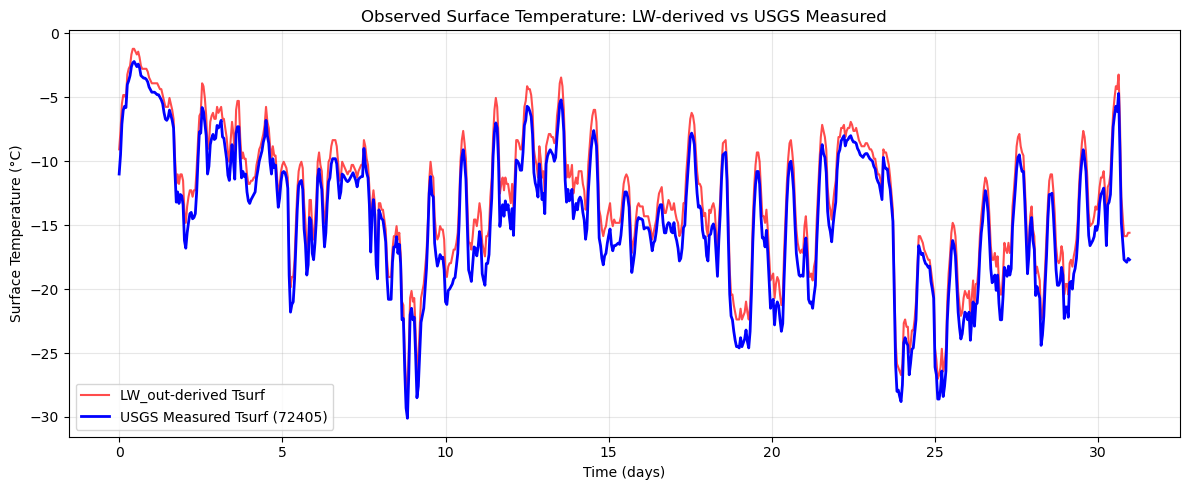

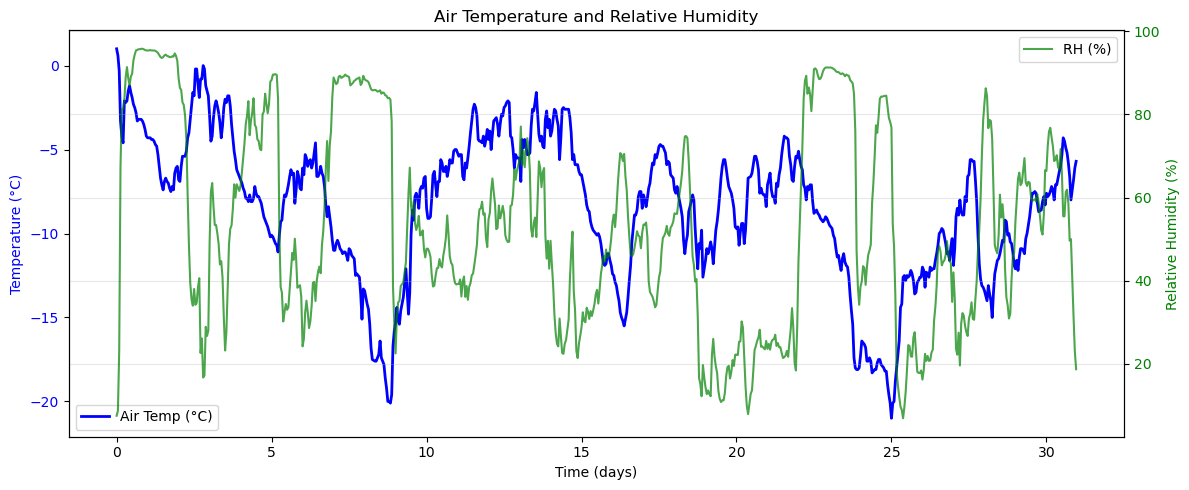

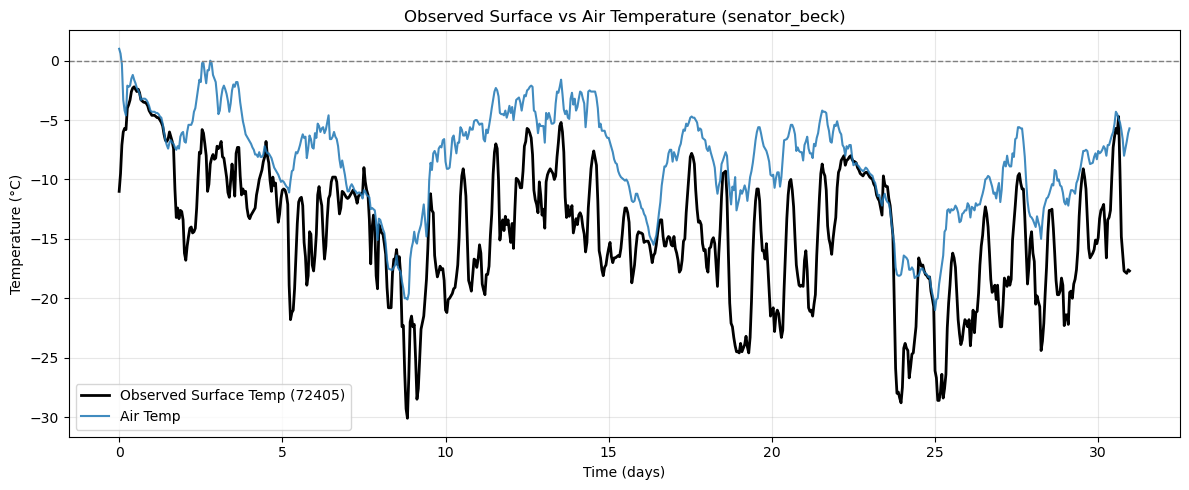

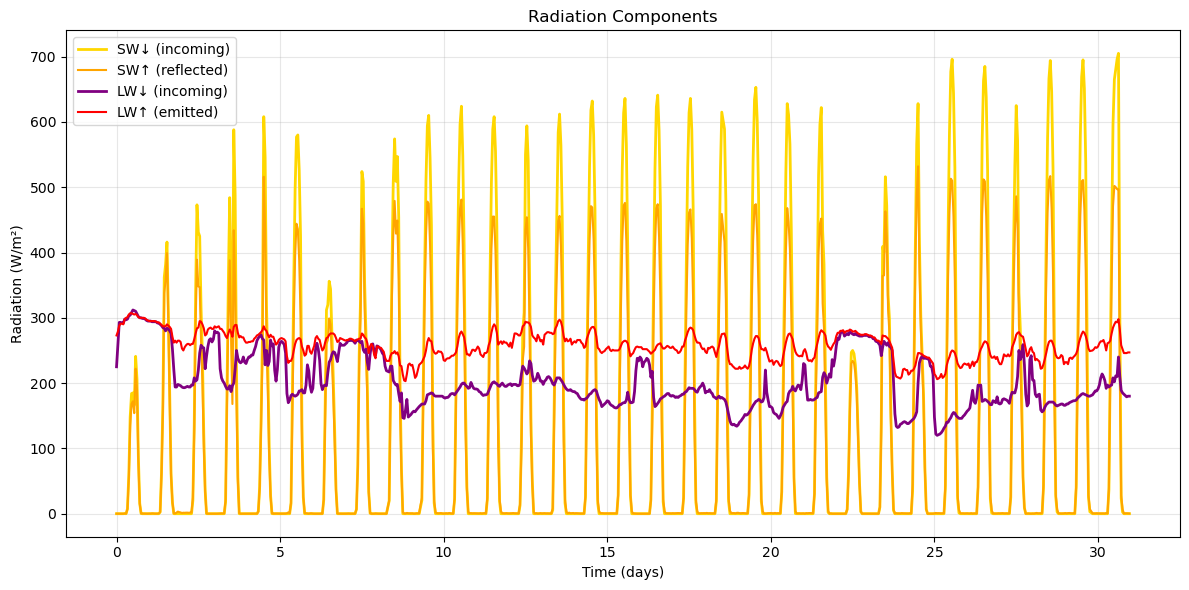

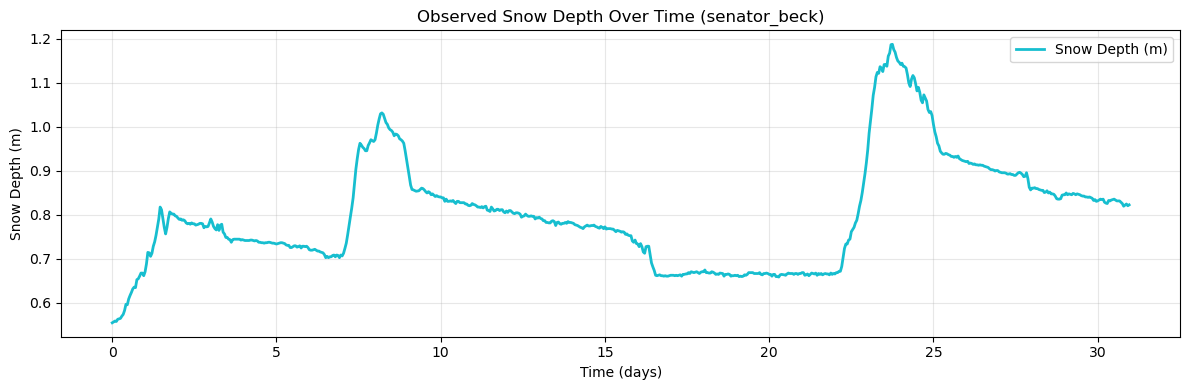

In [4]:
if show_plots:
    # Determine time axis (hours or days)
    max_time = times_arr.max()
    use_days = max_time > 72
    time_plot = times_arr / 86400 if use_days else times_arr
    time_label = "Time (days)" if use_days else "Time (hours)"
    
    # Plot 1: Surface Temperature Comparison
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(time_plot, lw_derived_surf_C, 'r-', alpha=0.7, label='LW_out-derived Tsurf')
    ax.plot(time_plot, df['surface_temp_c'].values, 'b-', linewidth=2, label='USGS Measured Tsurf (72405)')
    ax.set_xlabel(time_label)
    ax.set_ylabel("Surface Temperature (°C)")
    ax.set_title("Observed Surface Temperature: LW-derived vs USGS Measured")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Air Temperature and RH
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.plot(time_plot, df['air_temp_c'].values, 'b-', linewidth=2, label='Air Temp (°C)')
    ax1.set_xlabel(time_label)
    ax1.set_ylabel("Temperature (°C)", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.legend(loc='lower left')
    
    ax2 = ax1.twinx()
    ax2.plot(time_plot, df['rh_pct'].values, 'g-', alpha=0.7, label='RH (%)')
    ax2.set_ylabel("Relative Humidity (%)", color='g')
    ax2.tick_params(axis='y', labelcolor='g')
    ax2.legend(loc='upper right')
    
    plt.title("Air Temperature and Relative Humidity")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 3: Observed Surface Temperature vs Air Temperature
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(time_plot, df['surface_temp_c'].values, color='black', linewidth=2,
            label='Observed Surface Temp (72405)')
    ax.plot(time_plot, df['air_temp_c'].values, color='tab:blue', alpha=0.85,
            label='Air Temp')
    ax.axhline(0.0, color='gray', linestyle='--', linewidth=1)
    ax.set_xlabel(time_label)
    ax.set_ylabel("Temperature (°C)")
    ax.set_title(f"Observed Surface vs Air Temperature ({STATION})")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot 4: Radiation Components
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time_plot, df['sw_down_wm2'].values, 'gold', linewidth=2, label='SW↓ (incoming)')
    ax.plot(time_plot, df['sw_up_wm2'].values, 'orange', linewidth=1.5, label='SW↑ (reflected)')
    ax.plot(time_plot, df['lw_down_wm2'].values, 'purple', linewidth=2, label='LW↓ (incoming)')
    if 'lw_up_wm2' in df.columns:

        ax.plot(time_plot, df['lw_up_wm2'].values, 'red', linewidth=1.5, label='LW↑ (emitted)')
    ax.set_xlabel(time_label)
    ax.set_ylabel("Radiation (W/m²)")
    ax.set_title("Radiation Components")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Plot 5: Snow Depth 
    time_sec_local = (df.index - df.index[0]).total_seconds().values
    use_days_local = time_sec_local.max() > 72 * 3600
    x_time = time_sec_local / (86400 if use_days_local else 3600)
    x_label = "Time (days)" if use_days_local else "Time (hours)"

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x_time, df["snow_depth_m"].values, color="tab:cyan", linewidth=2, label="Snow Depth (m)")
    ax.set_xlabel(x_label)
    ax.set_ylabel("Snow Depth (m)")
    ax.set_title(f"Observed Snow Depth Over Time ({STATION})")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

## Snow Layer Construction

Divide the snowpack into N layers for numerical solution.

In [5]:
# Divides the snowpack into N layers
# Temperatures are stored at the midpoints of each layer (z_T)
# The faces of the layers are stored in z_F array

z_F = np.linspace(0.0, snow_depth_m, N+1)   # N+1 faces for N layers
z_T = 0.5*(z_F[:-1] + z_F[1:])              # Layer midpoints
dz  = z_F[1:] - z_F[:-1]                    # Thickness of each layer
H   = z_F[-1]                               # Should match snow_depth_m

print(f"Snow Depth = {H:.3f} m with {N} layers; each ~{dz[0]:.4f} m thick")

Snow Depth = 1.500 m with 35 layers; each ~0.0429 m thick


## Set Initial Temperature Profile

Create initial conditions using USGS surface temperature and assuming 0°C at ground.

In [6]:
T_ground = 273.15  # Ground temperature (0°C)
T_snow_min = df['surface_temp_c'].iloc[0] + 273.15  # Initial surface temp from USGS
H = snow_depth_m

# Define key points for PCHIP interpolation
x_key = np.array([0, 0.2, H - 0.2, H])
T_key = np.array([T_snow_min, (T_snow_min + T_ground) / 2.0, 
                  (T_snow_min + T_ground) / 2.0, T_ground])

# Create PCHIP interpolator
pchip = PchipInterpolator(x_key, T_key)

# Convert layer midpoints to distance from surface
x_vals = H - z_T

# Compute initial temperature profile
T_init = pchip(x_vals)
top_index = np.argmax(z_T)
T_init[top_index] = T_snow_min

print(f"Initial surface temperature: {T_snow_min - 273.15:.1f}°C")
print(f"Ground temperature: {T_ground - 273.15:.1f}°C")

Initial surface temperature: -11.0°C
Ground temperature: 0.0°C


## Physics Functions for Surface Energy Balance

This section implements the core physics for the surface energy balance (SEB). The net flux $F_{net}$ drives the temperature change of the top snow layer.

### 1. Radiative Fluxes
Net radiation $R_{net}$ is the sum of net shortwave ($SW_{net}$) and net longwave ($LW_{net}$) radiation:
$$ R_{net} = SW_{net} + LW_{net} $$

**Longwave Radiation:**
Outgoing longwave radiation is governed by the Stefan-Boltzmann Law:
$$ LW_{out} = \epsilon_{snow} \sigma T_{surf}^4 $$
where $\epsilon_{snow}$ is snow emissivity (approx 0.98) and $\sigma$ is the Stefan-Boltzmann constant.
Incoming longwave is either measured or parameterized based on air temperature and humidity (Brutsaert, 1975).

### 2. Turbulent Fluxes
Sensible ($Q_H$) and Latent ($Q_E$) heat fluxes are calculated using the **Bulk Aerodynamic Method**:
$$ Q_H = \rho_{air} C_p C_H U (T_{air} - T_{surf}) $$
$$ Q_E = \rho_{air} L_v C_E U (q_{air} - q_{surf}) $$
where $\rho_{air}$ is air density, $U$ is wind speed, and $C_H, C_E$ are bulk transfer coefficients (~0.002).

In [7]:
def measured_air_temp(t_sec):
    # Return air temperature in Kelvin
    # Uses interpolated USGS data (already converted to K in T_air_interp)
    return T_air_interp(t_sec)

def get_wind_speed(t_sec):
    # Wind speed in m/s (already converted)
    return wind_interp(t_sec)

def compute_specific_humidity(T_C, RH, p=p_air):
    if T_C >= 0.0:
        e_sat = 611 * np.exp((17.27 * T_C) / (T_C + 237.3))
    else:
        e_sat = 611 * np.exp((22.46 * T_C) / (T_C + 272.62))
    e_act = RH * e_sat
    return (0.622 * e_act) / (p - (0.378 * e_act))

def get_air_specific_humidity(t_sec, p=p_air):
    T_airK = measured_air_temp(t_sec)
    T_airC = T_airK - 273.15
    RH_frac = RH_arr_interp(t_sec) / 100.0
    return compute_specific_humidity(T_airC, RH_frac, p)

def get_snow_specific_humidity(T_surfK, p=p_air):
    T_surfC = min(T_surfK - 273.15, 0.0)
    e_snow_sat = 611.0 * np.exp((22.46 * T_surfC) / (T_surfC + 272.62))
    return (0.622 * e_snow_sat) / (p - (0.378 * e_snow_sat))

def compute_atmospheric_emissivity(t_sec):
    # Brutsaert (1975) with cloud correction
    T_airK = measured_air_temp(t_sec)
    q_air = get_air_specific_humidity(t_sec)
    
    e_pa = q_air * p_air / (0.622 + 0.378 * q_air)
    e_hPa = e_pa / 100.0
    
    eps_atm = 1.24 * (e_hPa / T_airK)**(1.0/7.0)
    
    # Cloud correction based on RH
    rh_val = RH_arr_interp(t_sec)
    if rh_val > 50:
        factor = (rh_val - 50.0) / 50.0
        eps_atm += 0.06 * min(factor, 1.0)
    
    return np.clip(eps_atm, 0.5, 1.0)

def compute_shortwave_net(t_sec):
    sw_in_val = SW_in_interp(t_sec)
    sw_out_val = SW_out_interp(t_sec)
    
    if use_idealized_SWout:
        # Use Modeled Albedo Aging
        return sw_in_val * (1.0 - alpha_snow)
    else:
        # Use Observed Net SW (limited to non-negative)
        return max(sw_in_val - sw_out_val, 0.0)
def turbulent_fluxes(t_sec, T_surfK):
    # Atmospheric Properties
    T_airK = measured_air_temp(t_sec)
    U = max(get_wind_speed(t_sec), 0.1)

    # Stability Correction (Bulk Richardson Number)
    z_ref_local = z_ref
    g = 9.81
    Ri_b = (g * z_ref_local * (T_airK - T_surfK)) / (T_airK * (U**2))

    if T_airK > T_surfK:
        # Stable branch: lighter suppression in daylight, stronger at night
        sw_in = SW_in_interp(t_sec)
        if sw_in > 80.0:
            stability_factor = 1.0 / (1.0 + 3.0 * max(Ri_b, 0.0))
            stability_factor = max(stability_factor, 0.50)
        else:
            stability_factor = 1.0 / (1.0 + 10.0 * max(Ri_b, 0.0))
            stability_factor = max(stability_factor, 0.20)
    else:
        # Unstable/neutral
        stability_factor = 1.0

    # Fluxes
    Q_sensible = rho_air * c_pa * CH * U * (T_airK - T_surfK) * stability_factor
    q_air = get_air_specific_humidity(t_sec)
    q_snow = get_snow_specific_humidity(T_surfK)
    Q_latent = rho_air * Lv_subl * CE * U * (q_air - q_snow) * stability_factor
    return Q_sensible, Q_latent


def compute_radiative_fluxes(t_sec, T_surfK):
    lw_down = LW_in_interp(t_sec)
    lw_up = eps_snow * sigma * (T_surfK ** 4)
    lw_net = lw_down - lw_up
    sw_net = max(SW_in_interp(t_sec) - SW_out_interp(t_sec), 0)
    return lw_net, sw_net

def compute_idealized_radiative_fluxes(t_sec, T_surfK):
    T_airK = measured_air_temp(t_sec)
    eps_atm = compute_atmospheric_emissivity(t_sec)
    LW_in_ideal = eps_atm * sigma * (T_airK ** 4)
    lw_up = eps_snow * sigma * (T_surfK ** 4)
    lw_net = LW_in_ideal - lw_up
    sw_net = max(SW_in_interp(t_sec) - SW_out_interp(t_sec), 0)
    return lw_net, sw_net

def shortwave_absorption_twoBand(t_sec, z_faces):
    sw_net = compute_shortwave_net(t_sec)
    
    f_nir = 0.4
    f_vis = 1.0 - f_nir
    kappa_nir = 35.0
    kappa_vis = 10.0
    
    sw_nir_top = sw_net * f_nir
    sw_vis_top = sw_net * f_vis
    
    # Derive H from max z coordinate
    H_curr = z_faces[-1]
    d_faces = H_curr - z_faces
    
    d_top = d_faces[1:]
    d_bottom = d_faces[:-1]
    
    flux_in_nir = sw_nir_top * np.exp(-kappa_nir * d_top)
    flux_out_nir = sw_nir_top * np.exp(-kappa_nir * d_bottom)
    SW_abs_nir = flux_in_nir - flux_out_nir
    
    flux_in_vis = sw_vis_top * np.exp(-kappa_vis * d_top)
    flux_out_vis = sw_vis_top * np.exp(-kappa_vis * d_bottom)
    SW_abs_vis = flux_in_vis - flux_out_vis
    
    return np.maximum(SW_abs_nir + SW_abs_vis, 0.0)

def enforce_melt_freeze(T, dTdt, tau=1800):
    for i in range(len(T)):
        if T[i] > 273.15:
            latent_cooling_rate = (T[i] - 273.15) / tau
            dTdt[i] -= latent_cooling_rate
            if dTdt[i] > 0:
                dTdt[i] = 0
    return T, dTdt

## Main dT/dt Equation

This function solves the **1D Heat Equation** for the snowpack temperature profile $T(z,t)$:
$$ \rho c \frac{\partial T}{\partial t} = \frac{\partial}{\partial z} \left( k \frac{\partial T}{\partial z} \right) + S(z) $$

**Discretization (Method of Lines):**
We discretize the spatial domain into $N$ layers and compute the flux $F$ at layer interfaces using Finite Differences:
$$ F_i = -k \frac{T_{i} - T_{i-1}}{dz} $$
The temperature rate of change for layer $i$ is:
$$ \frac{dT_i}{dt} = -\frac{F_{i+1} - F_{i}}{\rho c dz} + \frac{S_i}{\rho c} $$
where $S_i$ is the internal solar absorption source term.

In [8]:
def dT_dt(t_sec, T):
    # 1. Dynamic Snow Depth & Grid
    try:
        H_now = max(snow_depth_interp(t_sec), 0.1)
    except:
        H_now = 1.5
    dz_now = H_now / N
    
    # 2. Constant Thermal Properties
    rho_profile = np.full(N, rho_snow)
    k_face = np.full(N+1, k)
    
    # 3. Fluxes
    F = np.zeros(N+1)
    
    # Ground Flux
    F[0] = k_face[0] * (T_ground - T[0]) / dz_now
    
    # Internal Fluxes
    for i in range(1, N):
        F[i] = k_face[i] * (T[i-1] - T[i]) / dz_now
    
    # Surface Flux
    if use_idealized_LWin:
        net_radiative, _ = compute_idealized_radiative_fluxes(t_sec, T[-1])
    else:
        net_radiative, _ = compute_radiative_fluxes(t_sec, T[-1])
    
    Q_sensible, Q_latent = turbulent_fluxes(t_sec, T[-1])
    
    F[N] = -(net_radiative + Q_sensible + Q_latent)
    
    # 4. Temperature Tendency
    dTdt = np.zeros(N)
    # Heat Capacity (Volumetric): rho * c
    # c_snow is constant (2090 J/kgK)
    vol_heat_cap = rho_profile * c_snow
    
    for i in range(N):
        dTdt[i] = -(F[i+1] - F[i]) / (vol_heat_cap[i] * dz_now)
    
    # 5. Shortwave Absorption
    if use_twoBand:
        z_faces_now = np.linspace(0, H_now, N+1)
        SW_profile = shortwave_absorption_twoBand(t_sec, z_faces_now)
    else:
        SW_profile = np.zeros(N)
    for i in range(N):
        dTdt[i] += SW_profile[i] / (vol_heat_cap[i] * dz_now)
    
    # 6. Melt/Freeze
    T, dTdt = enforce_melt_freeze(T, dTdt, tau=1800)
    
    return dTdt

## Run Multiple SW/LW Scenarios

Compare 4 scenarios: measured vs idealized for both SW and LW.

Running scenarios...
  Measured SW out, Measured LW in...
Done!
Model hours: 0.0 to 743.0
Data  hours: 0.0 to 743.0


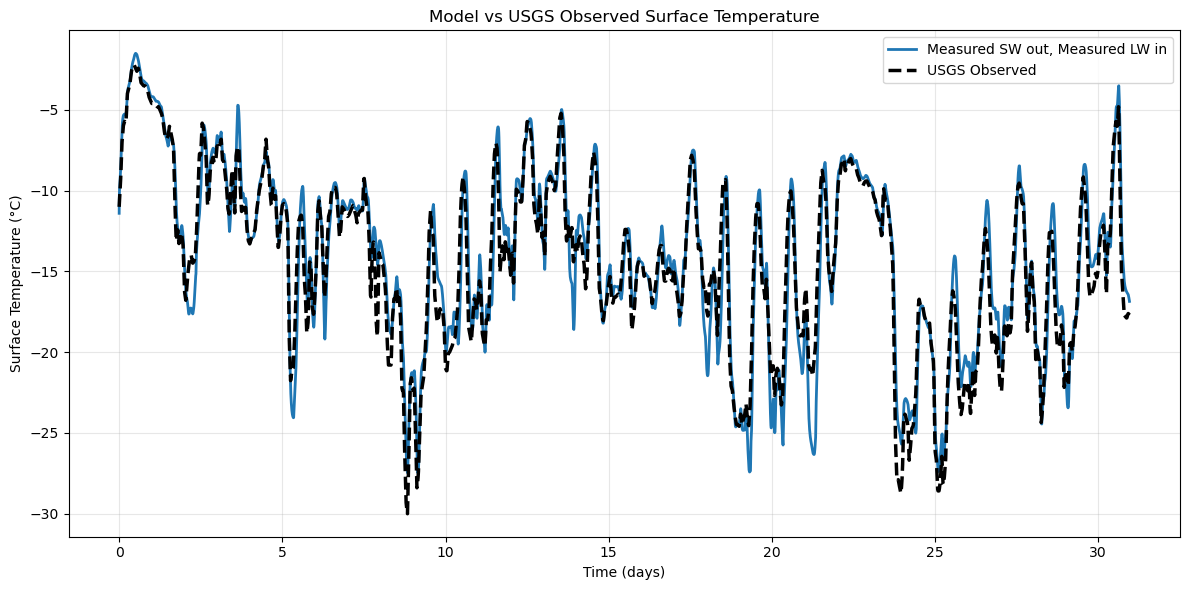

In [9]:
def run_snow_model(use_idealized_SW_local, use_idealized_LW_local):
    global use_idealized_SWout, use_idealized_LWin
    old_SW = use_idealized_SWout
    old_LW = use_idealized_LWin
    
    use_idealized_SWout = use_idealized_SW_local
    use_idealized_LWin = use_idealized_LW_local
    
    sol = solve_ivp(fun=dT_dt,
                    t_span=(0, t_end),
                    y0=T_init,
                    method='RK45',
                    max_step=dt_max,
                    rtol=1e-5,
                    atol=1e-7)
    
    use_idealized_SWout = old_SW
    use_idealized_LWin = old_LW
    
    # Calculate fluxes using the SAME scenario settings as the model run
    # This ensures diagnostic plots match what the solver actually used
    fluxes = {'net_radiative': [], 'sensible': [], 'latent': [], 'net_energy': []}
    for i, t_sec in enumerate(sol.t):
        T_surf = sol.y[-1, i]
        
        # Use the same LW setting that the solver used
        if use_idealized_LW_local:
            net_radiative, _ = compute_idealized_radiative_fluxes(t_sec, T_surf)
        else:
            net_radiative, _ = compute_radiative_fluxes(t_sec, T_surf)
        
        Q_sensible, Q_latent = turbulent_fluxes(t_sec, T_surf)
        fluxes['net_radiative'].append(net_radiative)
        fluxes['sensible'].append(Q_sensible)
        fluxes['latent'].append(Q_latent)
        fluxes['net_energy'].append(net_radiative + Q_sensible + Q_latent)
    
    return sol.t, sol.y, fluxes

# Define scenarios
if run_measured_only:
    scenarios = {
        "Measured SW out, Measured LW in": (False, False)
    }
else:
    scenarios = {
        "Measured SW out, Measured LW in":   (False, False),
        "Measured SW out, Idealized LW in":  (False, True),
        "Idealized SW out, Measured LW in":  (True,  False),
        "Idealized SW out, Idealized LW in": (True,  True)
}

results = {}

print("Running scenarios...")
for label, (sw_bool, lw_bool) in scenarios.items():
    print(f"  {label}...")
    t_run, T_layers_run, fluxes_run = run_snow_model(sw_bool, lw_bool)
    results[label] = {
        'time_sec': t_run,
        'T_layers': T_layers_run,
        'fluxes': fluxes_run
    }
print("Done!")

t_check = results["Measured SW out, Measured LW in"]["time_sec"]
print("Model hours:", round(t_check[0]/3600, 2), "to", round(t_check[-1]/3600, 2))
print("Data  hours:", round(times_sec[0]/3600, 2), "to", round(times_sec[-1]/3600, 2))


def model_surface_series_C(t_model, T_layers_K, use_skin=False, beta=0.20):

    if (not use_skin) or (T_layers_K.shape[0] < 2):

        return T_layers_K[-1, :] - 273.15

    T_top = T_layers_K[-1, :]

    T_below = T_layers_K[-2, :]

    grad = np.clip(T_top - T_below, -2.0, 2.0)

    T_skin = np.clip(T_top + beta * grad, 223.15, 273.15)

    return T_skin - 273.15


# Plot surface temperatures
plt.figure(figsize=(12, 6))
for label in scenarios:
    t_model = results[label]['time_sec']
    T_surf_C = model_surface_series_C(t_model, results[label]['T_layers'], use_skin=USE_SKIN_DIAGNOSTIC, beta=SKIN_BETA)
    plt.plot(t_model/(3600*24), T_surf_C, label=label, linewidth=2)

# Add observed
some_t_sec = results["Measured SW out, Measured LW in"]['time_sec']
usgs_surf_C = usgs_temp_obs_interp(some_t_sec)
plt.plot(some_t_sec/(3600*24), usgs_surf_C, 'k--', linewidth=2.5, label='USGS Observed')

plt.xlabel("Time (days)")
plt.ylabel("Surface Temperature (°C)")
plt.title("Model vs USGS Observed Surface Temperature")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Error Analysis

Compare model output to USGS observed surface temperature.

ERROR ANALYSIS vs USGS MEASURED SURFACE TEMPERATURE

USGS Surface Temp (72405)
SCENARIO                               MAE   RMSE   BIAS   CORR  DAY Δ  NIGHT Δ
Measured SW out, Measured LW in       1.15   1.63   0.10  0.957  -0.03     0.23

--- Plots use USGS measured surface temperature as reference ---


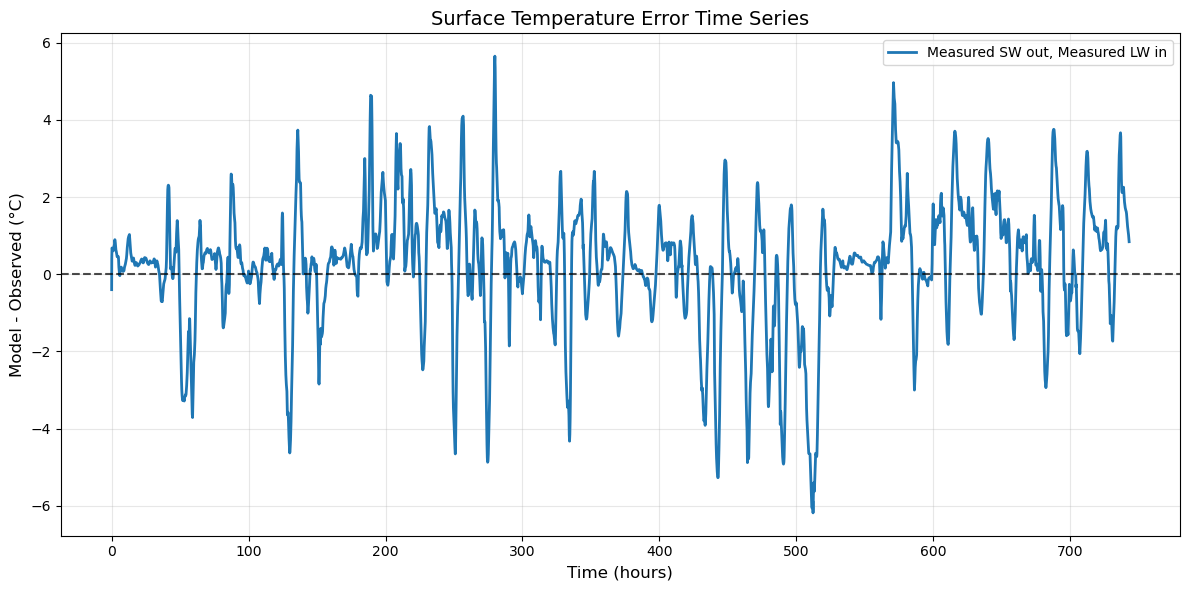

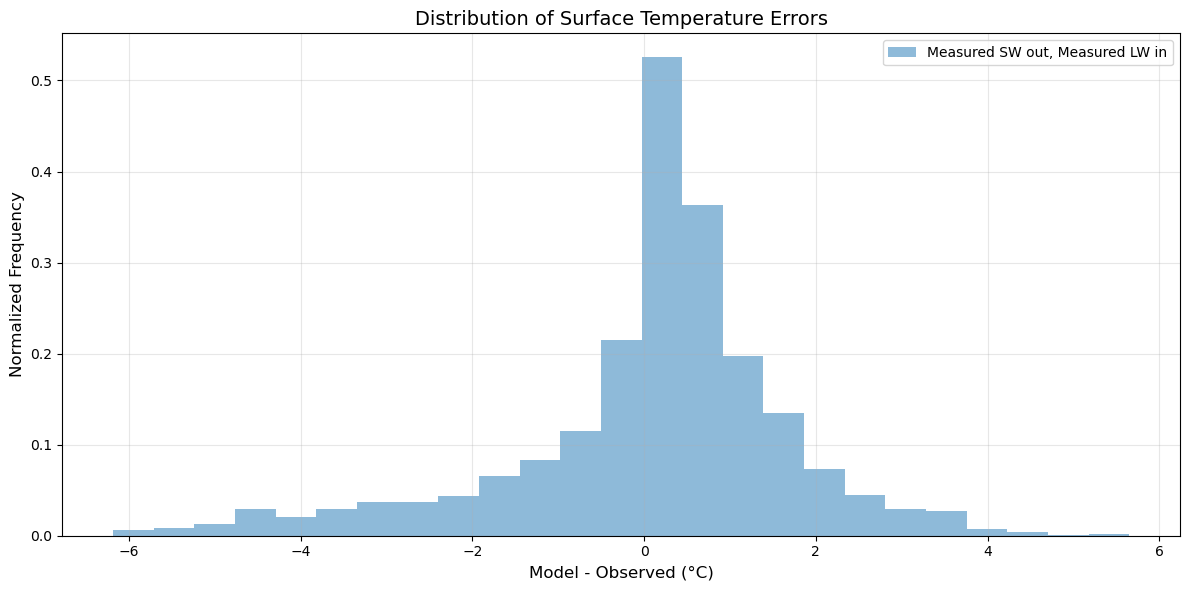

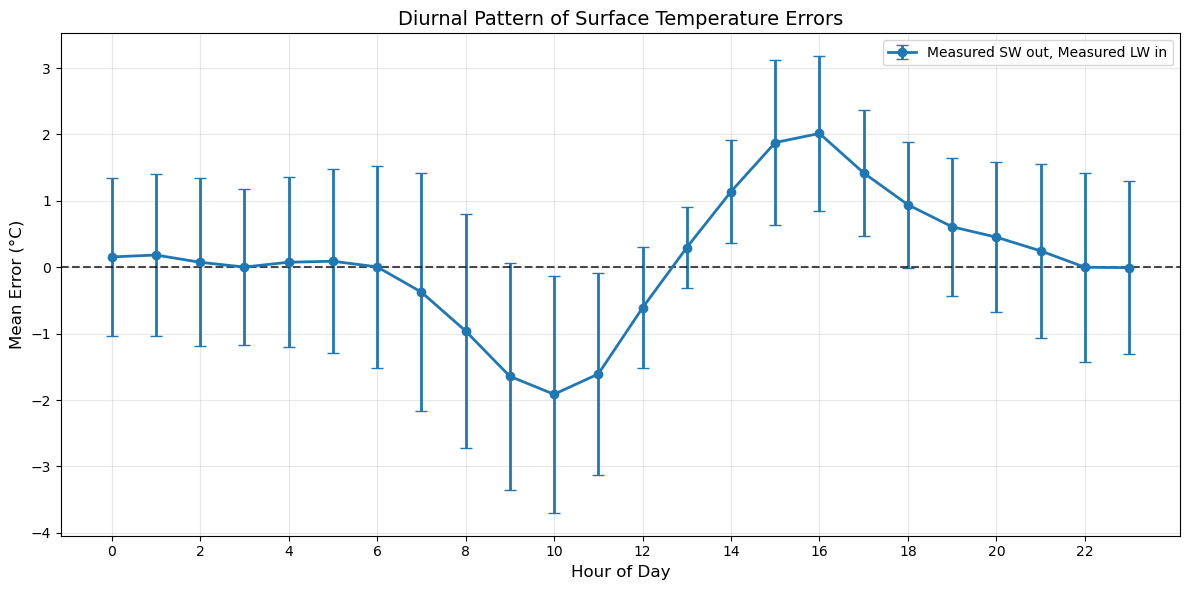

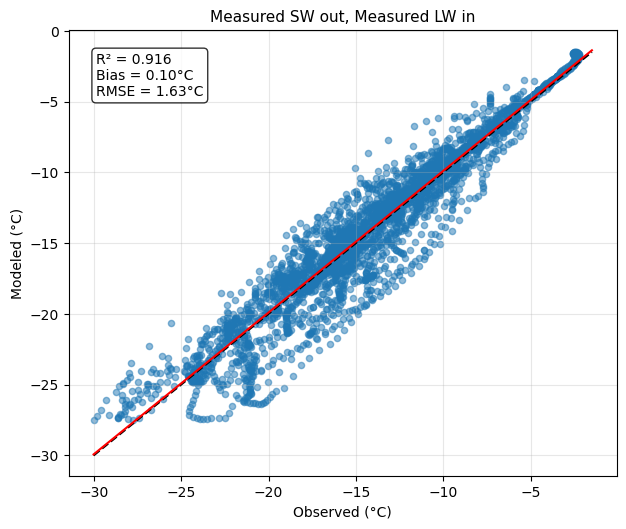

In [10]:
# =============================================================================
# ERROR ANALYSIS FUNCTIONS
# =============================================================================

def analyze_model_errors(results, observed_data_function):
    """Analyze model errors compared to observed surface temperature."""
    scenario_errors = {}
    scenario_stats = {}
    
    for label, data in results.items():
        t_model = data['time_sec']
        T_surf_C = model_surface_series_C(t_model, data['T_layers'], use_skin=USE_SKIN_DIAGNOSTIC, beta=SKIN_BETA)
        obs_surf_tempC = observed_data_function(t_model)
        error = T_surf_C - obs_surf_tempC
        
        scenario_errors[label] = {
            'time_sec': t_model,
            'error': error,
            'observed': obs_surf_tempC,
            'modeled': T_surf_C
        }
        
        mae = np.mean(np.abs(error))
        rmse = np.sqrt(np.mean(error**2))
        bias = np.mean(error)
        correlation = np.corrcoef(obs_surf_tempC, T_surf_C)[0, 1]
        
        hours = [(t % (24*3600))/3600 for t in t_model]
        day_mask = np.array([(6 <= h <= 18) for h in hours])
        night_mask = ~day_mask
        
        day_bias = np.mean(error[day_mask]) if np.any(day_mask) else np.nan
        night_bias = np.mean(error[night_mask]) if np.any(night_mask) else np.nan
        
        scenario_stats[label] = {
            'MAE': mae, 'RMSE': rmse, 'Bias': bias,
            'Correlation': correlation, 'Day Bias': day_bias, 'Night Bias': night_bias
        }
    
    return scenario_errors, scenario_stats

def plot_error_timeseries(scenario_errors):
    """Plot time series of errors for each scenario."""
    plt.figure(figsize=(12, 6))
    for label, data in scenario_errors.items():
        time_hrs = data['time_sec'] / 3600.0
        plt.plot(time_hrs, data['error'], label=label, linewidth=2)
    plt.axhline(0, color='k', linestyle='--', alpha=0.7)
    plt.xlabel("Time (hours)", fontsize=12)
    plt.ylabel("Model - Observed (°C)", fontsize=12)
    plt.title("Surface Temperature Error Time Series", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    return plt.gcf()

def plot_error_histogram(scenario_errors):
    """Plot histogram of errors for each scenario."""
    plt.figure(figsize=(12, 6))
    for label, data in scenario_errors.items():
        plt.hist(data['error'], bins=25, alpha=0.5, label=label, density=True)
    plt.xlabel("Model - Observed (°C)", fontsize=12)
    plt.ylabel("Normalized Frequency", fontsize=12)
    plt.title("Distribution of Surface Temperature Errors", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    return plt.gcf()

def plot_diurnal_errors(scenario_errors):
    """Plot errors by hour of day to visualize diurnal patterns."""
    plt.figure(figsize=(12, 6))
    for label, data in scenario_errors.items():
        times = data['time_sec']
        hours = [(t % (24*3600))/3600 for t in times]
        error = data['error']
        
        hour_bins = np.arange(25)
        hour_indices = np.digitize(hours, hour_bins) - 1
        hourly_errors = [[] for _ in range(24)]
        
        for h_idx, err in zip(hour_indices, error):
            if 0 <= h_idx < 24:
                hourly_errors[h_idx].append(err)
        
        hour_means = [np.mean(errs) if errs else np.nan for errs in hourly_errors]
        hour_stds = [np.std(errs) if len(errs) > 1 else 0 for errs in hourly_errors]
        
        plt.errorbar(np.arange(24), hour_means, yerr=hour_stds, 
                    label=label, fmt='o-', capsize=4, linewidth=2)
    
    plt.axhline(0, color='k', linestyle='--', alpha=0.7)
    plt.xlabel("Hour of Day", fontsize=12)
    plt.ylabel("Mean Error (°C)", fontsize=12)
    plt.title("Diurnal Pattern of Surface Temperature Errors", fontsize=14)
    plt.xticks(np.arange(0, 24, 2))
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    return plt.gcf()

def plot_scatter_comparison(scenario_errors):
    """Create scatter plot of observed vs modeled temperatures."""
    plt.figure(figsize=(12, 10))
    for i, (label, data) in enumerate(scenario_errors.items()):
        plt.subplot(2, 2, i+1)
        observed = data['observed']
        modeled = data['modeled']
        
        plt.scatter(observed, modeled, alpha=0.5, s=20)
        
        min_val = min(np.min(observed), np.min(modeled))
        max_val = max(np.max(observed), np.max(modeled))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1')
        
        z = np.polyfit(observed, modeled, 1)
        p = np.poly1d(z)
        plt.plot([min_val, max_val], p([min_val, max_val]), 'r-', label='Fit')
        
        r2 = np.corrcoef(observed, modeled)[0, 1]**2
        bias = np.mean(modeled - observed)
        rmse = np.sqrt(np.mean((modeled - observed)**2))
        plt.text(0.05, 0.95, f"R² = {r2:.3f}\nBias = {bias:.2f}°C\nRMSE = {rmse:.2f}°C", 
                 transform=plt.gca().transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.title(label, fontsize=11)
        plt.xlabel("Observed (°C)")
        plt.ylabel("Modeled (°C)")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return plt.gcf()

def display_error_stats_table(scenario_stats, title=""):
    """Display a formatted table of error statistics."""
    if title:
        print(f"\n{title}")
    header = f"{'SCENARIO':<35} {'MAE':>6} {'RMSE':>6} {'BIAS':>6} {'CORR':>6} {'DAY Δ':>6} {'NIGHT Δ':>8}"
    separator = "=" * len(header)
    print(header)
    print(separator)
    for label, stats in scenario_stats.items():
        print(f"{label:<35} {stats['MAE']:6.2f} {stats['RMSE']:6.2f} {stats['Bias']:6.2f} "
              f"{stats['Correlation']:6.3f} {stats['Day Bias']:6.2f} {stats['Night Bias']:8.2f}")
    print(separator)

def run_measured_stats():
    t_run, T_layers_run, fluxes_run = run_snow_model(False, False)
    one_result = {
        "Measured SW out, Measured LW in": {
            "time_sec": t_run,
            "T_layers": T_layers_run,
            "fluxes": fluxes_run
        }
    }
    _, stats = analyze_model_errors(one_result, usgs_temp_obs_interp)
    return stats["Measured SW out, Measured LW in"]


# =============================================================================
# RUN ERROR ANALYSIS
# =============================================================================

# PRIMARY: Compare against USGS measured surface temperature (72405)
print("=" * 70)
print("ERROR ANALYSIS vs USGS MEASURED SURFACE TEMPERATURE")
print("=" * 70)
scenario_errors_usgs, scenario_stats_usgs = analyze_model_errors(results, usgs_temp_obs_interp)
display_error_stats_table(scenario_stats_usgs, "USGS Surface Temp (72405)")

# Plot error visualizations (using USGS as primary)
print("\n--- Plots use USGS measured surface temperature as reference ---")
plot_error_timeseries(scenario_errors_usgs)
plt.show()

plot_error_histogram(scenario_errors_usgs)
plt.show()

plot_diurnal_errors(scenario_errors_usgs)
plt.show()

plot_scatter_comparison(scenario_errors_usgs)
plt.show()

## Animation: Temperature Profile Evolution

Generate animated GIF of temperature profiles for all scenarios.

In [11]:
if generate_animation:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    lines = []
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for i, (label, _) in enumerate(scenarios.items()):
        line, = ax.plot([], [], '-o', color=colors[i], label=label, markersize=3)
        lines.append(line)
    
    first_scenario = list(results.values())[0]
    time = first_scenario['time_sec']
    
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes,
                       bbox=dict(facecolor='white', alpha=0.7))
    
    def init_anim():
        ax.set_xlim(-30, 2)
        ax.set_ylim(-0.25, H + 0.5)
        ax.set_xlabel("Temperature (°C)")
        ax.set_ylabel("Depth (m)")
        ax.set_title("Snow Temperature Profile Evolution")
        ax.grid(True, alpha=0.3)
        ax.axhspan(-0.25, 0, color='brown', alpha=0.3)
        ax.axhspan(H, H + 0.5, color='skyblue', alpha=0.2)
        ax.legend(loc='upper right')
        return lines + [time_text]
    
    def animate(frame):
        total_frames = 50
        idx = min(int(frame * len(time) / total_frames), len(time) - 1)
        hrs = time[idx] / 3600
        
        time_text.set_text(f'Time: {hrs:.1f} h ({hrs/24:.1f} days)')
        
        for j, (label, _) in enumerate(scenarios.items()):
            T_layers = results[label]['T_layers']
            if idx < T_layers.shape[1]:
                T_s = T_layers[:, idx] - 273.15
                lines[j].set_data(T_s, z_T)
        
        return lines + [time_text]
    
    try:
        ani = FuncAnimation(fig, animate, frames=50,
                          init_func=init_anim, interval=100, blit=True)
        ani.save('../figures/snowmodel_USGS_animation.gif', writer='pillow', fps=5)
        plt.close()
        display(Image('../figures/snowmodel_USGS_animation.gif'))
    except Exception as e:
        print(f"Error creating animation: {e}")
        plt.close()
else:
    print("Animation generation skipped.")

Animation generation skipped.
